In [ ]:
""" 
Copied from biasdir2,
should work for all biasdir 2+
Should replace bviasdir2 and 3
1. most analyses are in analysis_devo_task... for latest code]
2. here is additional stuff (i) touch positionl (ii) timecoures.
TO DO: combine them. Use analysis_devo for extracting data, and then add the below as additional plotting.
"""


In [1]:
%load_ext autoreload
%autoreload 2

%cd ..

/data1/code/python/drawmonkey


In [2]:
from tools.utils import * 
from tools.plots import *
from tools.analy import *
from tools.calc import *
from tools.analyplot import *
from tools.preprocess import *
from tools.dayanalysis import *
from analysis.line2 import *
from analysis.modelexpt import *

from pythonlib.drawmodel.analysis import *
from pythonlib.tools.stroketools import *
from analysis.probedatTaskmodel import *

NOTE: need to not overwrite strokes_all_task, because then the orders saved will stop being accurate. Modify


## PLAN
1. Individual stroke directions are same regardless of overall sequence?
2. Within-day switching (like the summary plot for lines5, but separate by within day stage.



## SINGLE ANIMAL ANALYSIS - prototyping

In [56]:
expt = "biasdir3"
animal = "Pancho"
if False:
    dattoget = [
        (expt, "Red", "210107")]

    FD = loadMultData(dattoget)
    print("len(FD)")
    print(len(FD))
    
else:
    # saved exptdata
    FD, exptMetaDat = loadMultDataForExpt(expt, animal)
# PROBEDAT = PROBEDATfromFD(FD)
PROBEDAT = loadProbeDatWrapper(FD, exptMetaDat)
Probedat = ProbedatTaskmodel(PROBEDAT)

print("PROBLEM: need to make direction a param, diff biasdir have eitehr horiz or vert")

This is metadat:
{'sdate': 210108, 'edate': 210108, 'strokmodel_kind': None, 'strokmodel_tstamp': None, 'datecategories': {'210108': 1}, 'dates_for_summary': ['210108'], 'matchedstrokes': None, 'exptnames': ['biasdir3'], 'tasknames_G1': [], 'tasknames_G2': ['3line'], 'tasknames_G3': ['2line', '4line'], 'description': None, 'expt': 'biasdir3', 'task_train_test': {'probe1_liketrain': 'train', 'probe1_nostrokeconstraint': 'train', 'probe2_liketrain': 'train', 'probe2_nostrokeconstraint': 'train', 'probe3_hdpos': 'test', 'probe1': 'train', 'probe2': 'train', 'probe3': 'test', 'probe4': 'test', 'train': 'train'}}

Getting these dates:
['210108']
Pancho 210108 biasdir3 0
- No h5 file for Pancho, 210108, biasdir3, 0 - returning None!
Pancho 210108 biasdir3 1
-- loaded presaved data: /data2/animals/Pancho/210108/210108_151859_biasdir3_Pancho_1.pkl
got 515 total trials
appending fd for sess 1
Pancho 210108 biasdir3 2
- No h5 file for Pancho, 210108, biasdir3, 2 - returning None!
Pancho 210108 b

### Starting location for each stroke, separated by blocks

Conclusion: clear switching (blocks 3, 5, identical stimuli, only different is learned prior)
    

TO DO:
- assign to stroke numbers (see processAssignStrokes) (see below, have assigned, but problem is the numbers are not ordered left --> right)

## ASSIGN EACH STROKE TO GROUND TRUTH STROKE

### Summarize first touch position over blocks

In [57]:
SAVEDIR = f"{FD[0]['fd']['params']['figuredir_notebook']}/analysis_biasdir23456/{expt}/{animal}"
import os
os.makedirs(SAVEDIR, exist_ok=True)
print(f"saving at {SAVEDIR}")


saving at /data2/analyses/notebook/analysis_biasdir23456/biasdir3/Pancho


In [58]:
########## GET LABELS FOR STROKES
strokeslist_beh, tasks = Probedat.pd2strokes(Probedat.Probedat, return_all_trials=True)
blokk_global = extractFeature(Probedat, feat="blokk", returnlist=True)
assert len(blokk_global)==len(strokeslist_beh)

In [59]:
horiz=True

# ==== CONVERT TASKS TO TASK CLASS OBJECTS
from pythonlib.drawmodel.tasks import TaskClass
tasks = [TaskClass(t) for t in tasks]


# === 1) Assign each stroke to its corresponding task stroke.
stroke_assignments = []
for strokes_beh, T in zip(strokeslist_beh, tasks):
    if len(strokes_beh)==0:
        stroke_assignments.append([])
    else:
        A = T.behAssignClosestTaskStroke(strokes_beh)
        stroke_assignments.append(A)

# === 2) each task stroke, give it a label.
def func(task):
    # for each stroke, get its center's x coord
    coms = getCentersOfMass(task["strokes"])
    
    # rank their x positions (0 is leftmost,,,)
    from pythonlib.tools.nptools import rankItems
    if horiz:
        idx = 0
    else:
        idx = 1
    ranks = rankItems([c[idx] for c in coms])    
    return ranks    
[t.assignLabelToEachStroke(func) for t in tasks]
    
# === 3) each beh stroke can now get a label
beh_stroke_labels = [T.TaskLabels[ass] for ass, T in zip(stroke_assignments, tasks)]

######### GET OTHER DATA FOR EACH TRIAL
indslist = Probedat.getIndsTrials()
assert len(beh_stroke_labels)==len(indslist)
assert len(blokk_global)==len(indslist)
dat = []
for i in indslist:
    fd = Probedat.fd(i)
    t = Probedat.t(i)["trial"]
#     if len(beh_stroke_labels[i])==0:
#         print(getTrialsStrokesByPeanuts(fd, t))
#         plotTrialSimpleTimecourse(fd,t)
#         assert False
    if getTrialsStrokesByPeanuts(fd, t):
        dat.append({
#             "blokk": getTrialsBlokk(fd, t),
            "blokk": blokk_global[i],
            "block": getTrialsBlock(fd, t),
            "bloque": getTrialsBloque(fd, t),
            "trial":t,
            "label":beh_stroke_labels[i],
            "label_first_touch":beh_stroke_labels[i][0]
        })

In [60]:
### SUMMARIZE, for each blokk, get prob for each touch location being first.

df = pd.DataFrame(dat)

df

,blokk,block,bloque,trial,label,label_first_touch
0,0,1,1,5,"[1, 0]",1
1,0,1,1,7,"[1, 0]",1
2,0,1,1,10,"[0, 1, 2]",0
3,0,1,1,11,"[2, 0, 1]",2
4,0,1,1,12,"[2, 1, 0]",2
...,...,...,...,...,...,...
417,33,6,58,503,"[2, 1, 0]",2
418,34,7,59,505,[0],0
419,35,6,60,509,"[2, 1]",2
420,35,6,60,510,"[2, 1]",2


In [61]:
# def F(x):
#     dat = []
#     for pos in [0, 1, 2]:
#         dat.append(sum(x["label_first_touch"]==pos))
#     dat_norm = [d/sum(dat) for d in dat]
#     return pd.DataFrame(dat_norm)
def F(x):
    dat = []
    for pos in [0, 1, 2]:
        total = len(x["label_first_touch"])
        dat.append(
            {"label":str(pos),
             "block":x["block"].values[0],
             "prob":sum(x["label_first_touch"]==pos)/total})

    return pd.DataFrame(dat)
    
df2 = df.groupby(["blokk"]).apply(F).reset_index()
df2

,blokk,level_1,label,block,prob
0,0,0,0,1,0.111111
1,0,1,1,1,0.444444
2,0,2,2,1,0.444444
3,1,0,0,2,0.100000
4,1,1,1,2,0.316667
...,...,...,...,...,...
103,34,1,1,7,0.000000
104,34,2,2,7,0.000000
105,35,0,0,6,0.000000
106,35,1,1,6,0.000000


These are blocks: [1, 2, 3, 4, 5, 6, 7, 8]


/home/lucast4/miniconda3/envs/drag2/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/home/lucast4/miniconda3/envs/drag2/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/home/lucast4/miniconda3/envs/drag2/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/home/lucast4/miniconda3/envs/drag2/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/home/lucast4/miniconda3/env

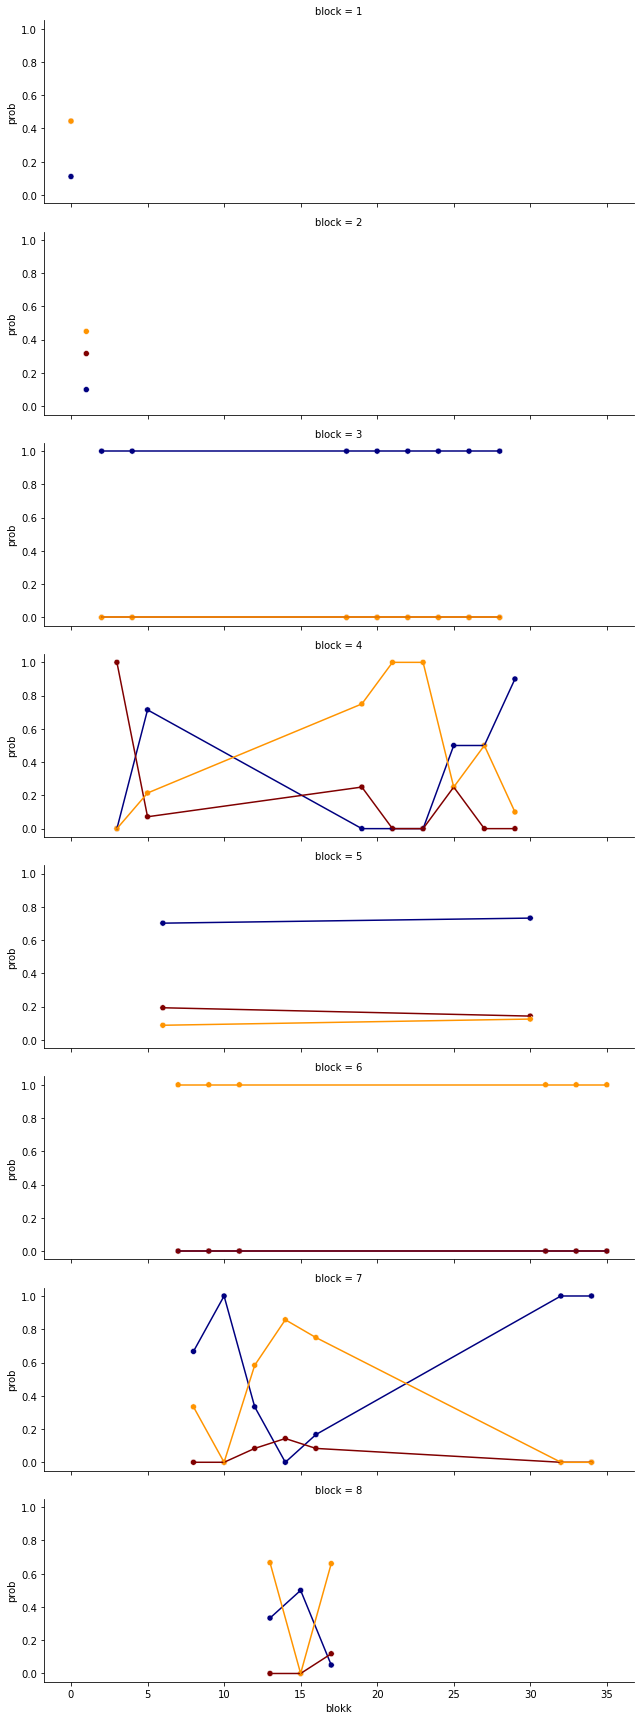

In [62]:
# === PLOT
from pythonlib.drawmodel.strokePlots import getStrokeColors
blocklist = sorted(list(set(df2["block"].values)))
print(f"These are blocks: {blocklist}")

if False:
    plt.figure(figsize=(15,7))
    sns.catplot(data=df2, x="blokk", y="prob", hue="label", aspect=2, row="block", sharex=True, height=3, 
               palette=getStrokeColors(5)[0])

if False:
    sns.relplot(data=df2, x="blokk", y="prob", hue="label", aspect=2, row="block", height=3, kind="line")


from pythonlib.tools.snstools import relPlotOverlayLineScatter
g = relPlotOverlayLineScatter(df2, "blokk", "prob", hue="label", row="block", palette = getStrokeColors(5)[0])
g.savefig(f"{SAVEDIR}/timecourse.pdf")

In [63]:
kk=0
trials = df[df["blokk"]==kk]["trial"].values
labels = df[df["blokk"]==kk]["label"].values
getTrialsBlock(fd, 10)

1

In [68]:
labels

array([array([2, 1]), array([2, 1]), array([2, 1, 0])], dtype=object)

In [77]:
pcollist = makeColors(3, 1, CMAP)
pcollist = np.concatenate((pcollist, pcollist[2,:][None, :]), axis=0)

array([[0.        , 1.        , 1.        , 1.        ],
       [0.50196078, 0.49803922, 1.        , 1.        ],
       [1.        , 0.        , 1.        , 1.        ],
       [1.        , 0.        , 1.        , 1.        ]])

In [78]:
## HACK, to make the last (4) stroke have same color as the 3rd, or else the rightmost will not look 
# like the rightmost.
# FIX: plot by gradient...

pcollist = makeColors(3, 1, CMAP)

pcollist = np.concatenate((pcollist, pcollist[2,:][None, :]), axis=0)

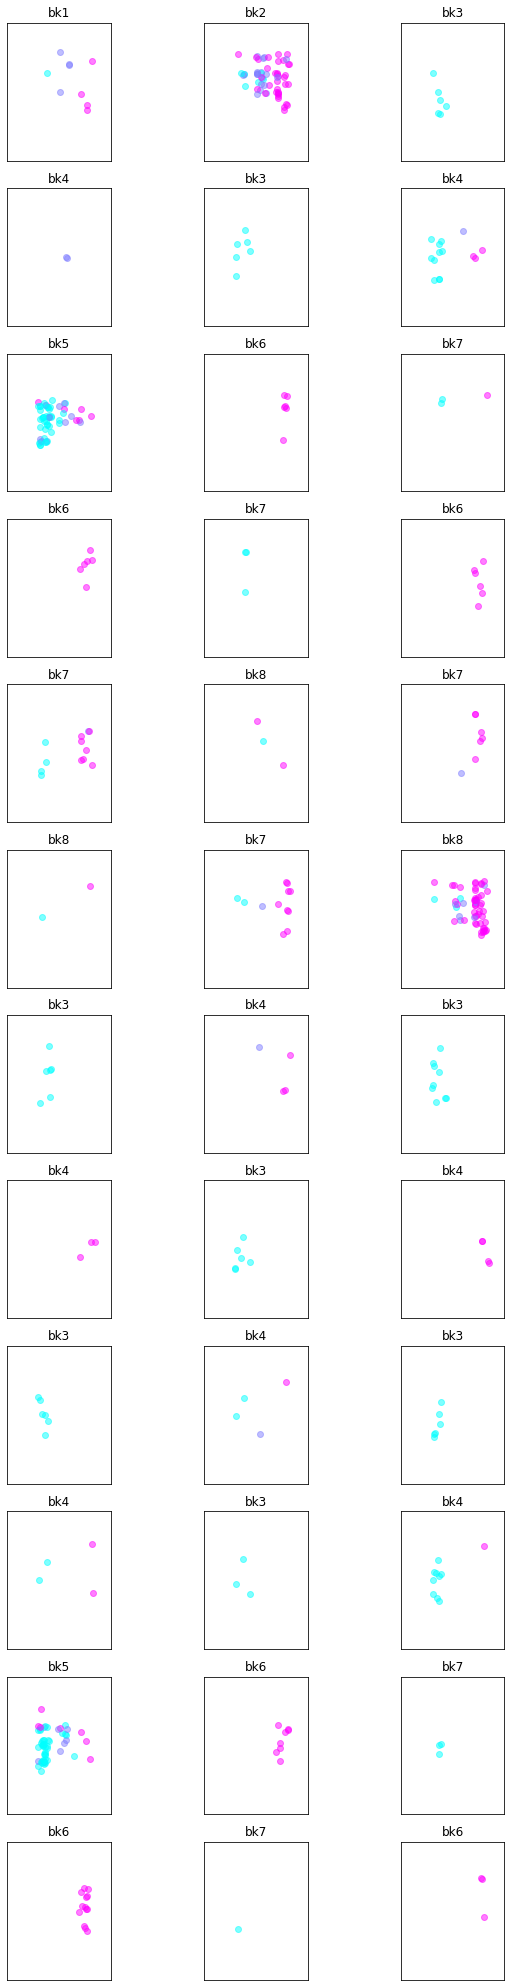

In [79]:
# === PLOT, POSITIONS OF FIRST TOUCH.
# -- Initialize one figure for each blokk
from pythonlib.tools.plottools import makeColors
CMAP = "cool"

df = pd.DataFrame(dat)
bkklist = set(df["blokk"])
naxes = len(bkklist)
ncols = 3
nrows = int(np.ceil(naxes/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(10, nrows*3))

for i, kk in enumerate(bkklist):
    trials = df[df["blokk"]==kk]["trial"].values
    labels = df[df["blokk"]==kk]["label"].values
    ax = axes.flatten()[i]
    ax = plotGetBlankCanvas(fd, ax, no_xylim=True)[0]
    
    
    for t, label in zip(trials, labels):
        if getTrialsFixationSuccess(fd, t):
#             print(t)
#             assert False
            
            # === SANITY ChECK
            strokes = getTrialsStrokesByPeanuts(fd, t)
            
            if len(strokes)==0:
                print(getTrialsOutcomesWrapper(fd, t)["online_abort"]["failure_mode"])
                continue
                
            # -- assign first beh pt to a target stroke number.
#             if False:
#                 # old vrsion, just based on the storke order.
#                 strokes_task = getTrialsTaskAsStrokes(fd, t)
#                 strokenum = assignStrokenumFromTask(strokes, strokes_task)[0][0]
#             else:
#                 print(beh_stroke_labels[i], len(strokes))
            strokenum = label[0]
                
            if False:
                pcol = "k"
            elif False:
                pcol = getStrokeColors(5)[0][strokenum]
            else:
# #                 Ns = max([max(l) for l in labels])
#                 pcollist = makeColors(3, 1, CMAP)
#                 pcollist = np.concatenate((pcollist, pcollist[2,:][None, :]), axis=0)        
                pcol = pcollist[strokenum]
                
#             pcol = plot
            pos0 = strokes[0][0, [0,1]]
            ax.plot(pos0[0], pos0[1], 'o', color=pcol, alpha=0.5)
            
            # -- title
            bk = getTrialsBlock(fd, t)
#             bq = getTrialsBloque(fd, t)
            ax.set_title(f"bk{bk}")
#     plt.legend([1, 2, 3])
fig.savefig(f"{SAVEDIR}/first_touch_pos.pdf")

### SUMMARY PLOT ACROSS DAYS (EACH BLOKK ONE DOT)

Separating by task kind

### reaction/onset time, gap durations, etc.

1. Reaction time at onset of a new blokk - slower and then speeds up?
2. inter-stroke intervals longer for against-bias?
3. Reaction time slower for against bias?


In [ ]:
# === Plot some example timecourses
plot

In [ ]:
for p in P.Probedat:
    fd = p["filedata"]
    t = p["trial"]
    ontime = getTrialsOnsOffs(fd, t)[0][0]
    p["ontime"] = ontime
df = P.pandas()
import seaborn as sns

sns.catplot(data=df, x="taskgroup", y="ontime", kind="boxen",  hue="block", aspect=3)
plt.ylim([0, 10])

sns.catplot(data=df, x="taskgroup", y="ontime", kind="point", hue="block")
plt.ylim([0, 10])


### how does stroke direction depend on sequence bias?

### End-state comfort effect?

Is well-structured tasks, so easy to ask this.

## BELOW: MULTI-DAY STUFF, NOT YET DONE

In [ ]:
from analysis.probedatTaskmodel import *
animal = "Pancho"
expt = "biasdir2"
FD, MD = loadMultDataForExpt(expt, animal, whichdates="all", metadatonly=False)
PROBEDAT = loadProbeDatWrapper(FD, MD, getnumstrokes=True)
Probedat = ProbedatTaskmodel(PROBEDAT, MD)



In [ ]:
                getTrialsOutcomesWrapper(fd, t)["online_abort"]["failure_mode"]

In [ ]:


ax = plotGetBlankCanvas(fd)
for t in getIndsTrials(fd):
    if getTrialsFixationSuccess(fd, t):
        strokes = getTrialsStrokesByPeanuts(fd, t)

        pos0 = strokes[0][0, [0,1]]
        plt.plot(pos0[0], pos0[1], 'or')


## Scores across days

In [ ]:
valstoplot = ["hausdorff_positive", "modelscore", "frac_touched"]
SEPARATE_BY_BLOCK = True # whether should make seperate tiemcourse plotes fore ach block num.

In [ ]:
# 1) Load data across days
from pythonlib.tools.datetools import getDateList
from analysis.line2 import PROBEDATfromFD
import seaborn as sns
import pandas as pd
from analysis.line2 import probedat2strokefeats, getStandardizedTime
from analysis.modelexpt import *

for animal in ["Red", "Pancho"]:
    expt = "mem123"
    # for animal in ["Pancho", "Red"]:
    # for animal in ["Red"]:
    # for animal in ["Red"]:
    # for animal in ["Pancho"]:

    FD, MD = loadMultDataForExpt(expt, animal, whichdates="all", metadatonly=False)

    PROBEDAT = loadProbeDatWrapper(FD, MD, getnumstrokes=True)

    from analysis.probedatTaskmodel import *
    Probedat = ProbedatTaskmodel(PROBEDAT, MD)


    # saving dir
    SAVEDIR = f"{FD[0]['fd']['params']['figuredir_notebook']}/analysis_modelexpt_multsession/{expt}/multday_{animal}_{MD['sdate']}_to_{MD['edate']}/taskmodel"
    import os
    os.makedirs(SAVEDIR, exist_ok=True)
    print(f"saving at {SAVEDIR}")

    if MD["strokmodel_kind"] is not None:
        # ***************************************** COMPUTE MODEL SCORE OFFLIEN
        PROBEDAT, fig = probedatOfflineScore(PROBEDAT, filtdict={"random_task":[False]}, 
                                       ploton=True)
        fig.savefig(f"{SAVEDIR}/offlineScorePairplot.pdf")



    # ********************************************************
    # **************************** extract dataframe
    if True:
        # new version, all done within here.
        DF = Probedat.pandas()
    else:
        # OLD
        DF = pd.DataFrame(PROBEDAT)
        from pythonlib.tools.pandastools import applyFunctionToAllRows
        def F(x):
            return np.floor(x["tval"])+0.6
        DF = applyFunctionToAllRows(DF, F, newcolname="tvalday")

        from pythonlib.tools.pandastools import applyFunctionToAllRows
        # === flip score around 0 depending on epoch
        def F(x):
            if x["epoch"]==1:
                return x["modelcomp"]
            elif x["epoch"]==2:
                return -x["modelcomp"]
            else:
                print(x["epoch"])
                assert False, "which eopch?"
        DF = applyFunctionToAllRows(DF, F, newcolname="modelcompflipped")

        # === flip score around 0 depending on epoch
        def F(x):
            return -x["hausdorff"]
        DF = applyFunctionToAllRows(DF, F, newcolname="hausdorff_positive")

        ## ============ COMPARE TWO EPOCHS (ONE SCORE FOR EACH)
        # first filter DF so that only keeps trials within the summary periods
        datestokeep = MD["dates_for_summary"]
        DF = applyFunctionToAllRows(DF, F=lambda x: x["date"] in datestokeep, newcolname="keepforsummary")

    # ********************************************************
    # *********************************** PLOTS
    # === GOOD PLOT, summarize task schedules.
    fig = sns.catplot(x="date", y="task_stagecategory", col = "random_task", row="taskgroup", hue="taskgroup", sharex=True,sharey=False,
                data=DF, height=10, aspect=2, orient="v")
    fig.savefig(f"{SAVEDIR}/overview1.pdf")

    # ==== GOOD PLOT (scatter and means)
    for y in valstoplot:
        ALPHA=0.4
        if y in ["modelcomp", "modelcompflipped"]:
            YLIM=(-0.7, 0.7)
        elif y=="modelcomp_offline":
            YLIM=(-1,1)
        elif y=="hausdorff_positive":
            YLIM=np.percentile(DF["hausdorff_positive"], q=[0.5, 99.5])
        elif y=="nstrokesactual":
            YLIM=np.percentile(DF["nstrokesactual"], q=[0.5, 99.5])
            YLIM = [YLIM[0]-0.5, YLIM[1]+0.5]
            ALPHA=0.15
        else:
            YLIM = None


        g = sns.FacetGrid(DF, row="task_stagecategory", col="taskgroup", height=4, aspect=2, 
                          sharex=True, sharey=True, ylim=YLIM)
        g.map(sns.lineplot, "tvalday", y, **{"err_style":"bars", "ci":68, "color":"k", "linewidth":2})
        g.map(sns.scatterplot, "tval", y, "epoch", **{"marker":"x", 
                                                      "alpha":ALPHA,
                                                              "s":40, 
                                                              "palette":{1:"r", 2:"b"}})
        g.map(plt.axhline, **{"color":[0.7, 0.7, 0.7]})
        g.savefig(f"{SAVEDIR}/alltimecourses-{y}-1.pdf")

        # == one plot for each block
        blocks = set(DF["block"])
        if SEPARATE_BY_BLOCK:
            for b in blocks:
                DFblock = DF[DF["block"]==b]
                g = sns.FacetGrid(DFblock, row="task_stagecategory", col="taskgroup", height=4, aspect=2, 
                          sharex=True, sharey=True, ylim=YLIM)
                g.map(sns.lineplot, "tvalday", y, **{"err_style":"bars", "ci":68, "color":"k", "linewidth":2})
                g.map(sns.scatterplot, "tval", y, "epoch", **{"marker":"x", 
                                                              "alpha":ALPHA,
                                                                      "s":40, 
                                                                      "palette":{1:"r", 2:"b"}})
                g.map(plt.axhline, **{"color":[0.7, 0.7, 0.7]})
                g.savefig(f"{SAVEDIR}/alltimecourses-{y}-1-block{b}.pdf")

            plt.close("all")

        # === summary (epoch1 vs. epoch2)
        DFsummary = DF[DF["keepforsummary"]==True]
        if len(DFsummary)>0:
            g = sns.FacetGrid(DFsummary, row="task_stagecategory", col="taskgroup", height=4, aspect=1.2, 
                              sharex=False, sharey=True, ylim=YLIM)
            g.map(sns.swarmplot, "epoch", y, "epoch", **{"alpha":ALPHA,
                                                                  "s":4, 
                                                                  "palette":{1:"r", 2:"b"}})
            g.map(sns.pointplot, "epoch", y, **{"err_style":"bars", "ci":68, "color":"k", "linewidth":1})
            g.map(plt.axhline, **{"color":[0.7, 0.7, 0.7]})
            g.savefig(f"{SAVEDIR}/alltimecourses-{y}-summary.pdf")

            if SEPARATE_BY_BLOCK:
                for b in blocks:
                    DFsummaryblock = DFsummary[DFsummary["block"]==b]
                    g = sns.FacetGrid(DFsummaryblock, row="task_stagecategory", col="taskgroup", height=4, aspect=1.2, 
                                      sharex=False, sharey=True, ylim=YLIM)
                    g.map(sns.swarmplot, "epoch", y, "epoch", **{"alpha":ALPHA,
                                                                          "s":4, 
                                                                          "palette":{1:"r", 2:"b"}})
                    g.map(sns.pointplot, "epoch", y, **{"err_style":"bars", "ci":68, "color":"k", "linewidth":1})
                    g.map(plt.axhline, **{"color":[0.7, 0.7, 0.7]})
                    g.savefig(f"{SAVEDIR}/alltimecourses-{y}-summary-block{b}.pdf")

                plt.close("all")


    # ***************************************
    # ***************************************
    # [one plot for each unqiue task]

    # === FIRST: THROW OUT RANDOM TASKS
    DF = DF[DF["random_task"]==False]

    if len(DF)>0:
        # ===== get dict of {taskgroup:[list of tasks]}
        tasklist = set(DF["task_stagecategory"])
        taskgrouplist = set(DF["taskgroup"])

        taskgroupdict = {k:[] for k in set([P["taskgroup"] for P in PROBEDAT])}
        for P in PROBEDAT:
            taskgroupdict[P["taskgroup"]].append(P["task_stagecategory"])

        for k, v in taskgroupdict.items():
            taskgroupdict[k] = sorted(set(v))


        # === one figure per taskgroup.
        for taskgroup, tasklist in taskgroupdict.items():
            for task in tasklist:
                DFthis = DF[(DF["taskgroup"]==taskgroup) & (DF["task_stagecategory"]==task)]
                if len(DFthis)>0:
                    for y in valstoplot:
                        ALPHA=0.4
                        if y in ["modelcomp", "modelcompflipped"]:
                            YLIM=(-0.7, 0.7)
                        elif y=="modelcomp_offline":
                            YLIM=(-1,1)
                        elif y=="hausdorff_positive":
                            YLIM=np.percentile(DF["hausdorff_positive"], q=[0.5, 99.5])
                        elif y=="nstrokesactual":
                            YLIM=np.percentile(DF["nstrokesactual"], q=[0.5, 99.5])
                            YLIM = [YLIM[0]-0.5, YLIM[1]+0.5]
                            ALPHA=0.15

                        g = sns.FacetGrid(DFthis, col="unique_task_name", col_wrap=5, height=4, aspect=2, 
                                          sharex=True, sharey=True, ylim=YLIM)
                        g.map(sns.lineplot, "tvalday", y, **{"err_style":"bars", "ci":68, "color":"k", "linewidth":2})
                        g.map(sns.scatterplot, "tval", y, "epoch", **{"marker":"x", 
                                                                      "alpha":ALPHA,
                                                                              "s":40, 
                                                                              "palette":{1:"r", 2:"b"}})
                        g.map(plt.axhline, **{"color":[0.7, 0.7, 0.7]})
                        g.savefig(f"{SAVEDIR}/timecourses-{taskgroup}-{task}-{y}-1.pdf")

                        # === summary
                        DFsummary = DFthis[DFthis["keepforsummary"]==True]
                        if len(DFsummary)>0:
                            g = sns.FacetGrid(DFsummary, col="unique_task_name", col_wrap=5, height=4, aspect=1.2, 
                              sharey=True, ylim=YLIM)
                            g.map(sns.swarmplot, "epoch", y, "epoch", **{"alpha":ALPHA,
                                                                                  "s":4, 
                                                                                  "palette":{1:"r", 2:"b"}})
                            g.map(sns.pointplot, "epoch", y, **{"err_style":"bars", "ci":68, "color":"k", "linewidth":1})
                            g.map(plt.axhline, **{"color":[0.7, 0.7, 0.7]})
                            g.savefig(f"{SAVEDIR}/timecourses-{taskgroup}-{task}-{y}-summary.pdf")


        # === ONE LINE PER UNIQUE TASK
        DFsummary = DF[DF["keepforsummary"]==True]

        # aggregate over unique tasks
        values = valstoplot
        from pythonlib.tools.pandastools import aggregGeneral
        DFsummary = aggregGeneral(DFsummary, ["unique_task_name", "epoch", "taskgroup"], values, nonnumercols=["task_stagecategory"], aggmethod=["median"])

        # == only keep cases that have data for both epochs.
        values_to_check = [1,2]
        colname = "epoch"
        group = "unique_task_name"
        from pythonlib.tools.pandastools import filterGroupsSoNoGapsInData
        DFsummary = filterGroupsSoNoGapsInData(DFsummary, group, colname, values_to_check)

        # === PLOT
        for y in values:
            from pythonlib.tools.snstools import relplotOverlaid
            fig = relplotOverlaid(DFsummary, "unique_task_name", "k",
                           data=DFsummary, x="epoch", y=y, col="taskgroup", row="task_stagecategory", 
                    hue="unique_task_name", kind="line")
            fig.savefig(f"{SAVEDIR}/summarypaired-{y}-1.pdf")

            fig = sns.catplot(data=DFsummary, x="epoch", y=y, col="taskgroup", row="task_stagecategory",  kind="point")
            fig.savefig(f"{SAVEDIR}/summarypaired-{y}-2.pdf")

## Plot task behaviors (below not done)

In [ ]:
expt = "mem123"
thingstoplot = ["alltrials", "egtrials"]


In [ ]:
def plotalltrials(PROBEDATthis, fdlist, stage, datelist, tasklist):
    tasklist = sorted(set([P["unique_task_name"] for P in PROBEDATthis if P["task_stagecategory"]==stage]))
    if len(tasklist)>100:
        assert False, "why so many tasks for this stage?"

    # -- Plot 2d grid, separated by days
    CAT1 = ["date", datelist]
    CAT2 = ["unique_task_name", tasklist]
    fdlist = None

    # == 1) All behavior trials, all strokes overlaid
    plotargs = {"zoom":True, "plotver":"order", "markersize":4, "alpha":0.25}
    # fdlist = [P["filedata"][0]() for P in PROBEDATthis]
    # fdlist = [FD[P["ii"]]["fd"] for P in PROBEDATthis]

    fig = plotTrial2dGrid(PROBEDATthis, fdlist = fdlist, cat1 = CAT1, cat2 = CAT2, ver="beh", plotargs=plotargs);
    fig.savefig(f"{SAVEDIR}/alltrials_datebycategory_beh_{stage}.pdf")
    fig = plotTrial2dGrid(PROBEDATthis, fdlist = fdlist, cat1 = CAT1, cat2 = CAT2, ver="task", plotargs=plotargs);
    fig.savefig(f"{SAVEDIR}/alltrials_datebycategory_task_{stage}.pdf")

    # == 2) Split by stroke number (one plot for each stroke)
    if False:
        plotargs = {"zoom":True, "plotver":"order", "markersize":3, "alpha":0.2}
        strokenums_to_plot_alone=list(range(max_strokenum+1))
        overlay_stroke_mean=False

        fig = plotTrial2dGrid(PROBEDATthis, fdlist = fdlist, cat1 = CAT1, cat2 = CAT2, ver="behtask", 
                              plotargs=plotargs, strokenums_to_plot_alone=strokenums_to_plot_alone, 
                             overlay_stroke_mean = overlay_stroke_mean);
        fig.savefig(f"{SAVEDIR}/alltrials_datebycategory_eachstroke_beh_{stage}.pdf")


    # == 3) All strokes (faint) and overlay average
    if False:
        plotargs = {"zoom":True, "plotver":"order", "markersize":2, "alpha":0.15}

        overlay_stroke_mean=True
        fig = plotTrial2dGrid(PROBEDATthis, fdlist = fdlist, cat1 = CAT1, cat2 = CAT2, ver="beh", 
                              plotargs=plotargs, overlay_stroke_mean=overlay_stroke_mean);
        fig.savefig(f"{SAVEDIR}/alltrials_datebycategory_strokemeans_{stage}.pdf")


In [ ]:
debug=False

### actual

In [ ]:
# Plot same task across days

# 1) Load data across days
from pythonlib.tools.datetools import getDateList
# expt = "lines2"
for animal in ["Pancho", "Red"]:
    
    FD, MD = loadMultDataForExpt(expt, animal, whichdates="all", metadatonly=False)
    PROBEDAT = loadProbeDatWrapper(FD, MD, getnumstrokes=True)

    # saving dir
    sdate = MD["sdate"]
    edate = MD["edate"]
    SAVEDIR = f"{FD[0]['fd']['params']['figuredir_notebook']}/analysis_modelexpt_multsession/{expt}/multday_{animal}_{sdate}_to_{edate}"
    import os
    os.makedirs(SAVEDIR, exist_ok=True)
    print(f"saving at {SAVEDIR}")

    # get all fixed tasks of a particular kind
    kindlist = set([P["kind"] for P in PROBEDAT if P["random_task"]==False])
    task_per_kind = {}
    for kind in kindlist:
        tasklist = set([P["unique_task_name"] for P in PROBEDAT if P["kind"]==kind])
        task_per_kind[kind]=sorted(tasklist)

    print("tasks per kind found")
    for k, v in task_per_kind.items():
        print("----")
        print(f"=={k}")
        [print(vv) for vv in v]


    ## PLOT - all trials, 2d grid sorted by date and task category
    # only keep data for fixed tasks.
    PROBEDATthis = [P for P in PROBEDAT if P["random_task"]==False]
    datelist = sorted(set([P["date"] for P in PROBEDATthis]))
    fdlist = None
    
    # for each stage, make a 2d grid plot (date x task)
    if "alltrials" in thingstoplot:
        # all categories that have fixed tasks
        stagelist = set([P["task_stagecategory"] for P in PROBEDATthis if P["random_task"]==False])
        for stage in stagelist:
            plotalltrials(PROBEDATthis, fdlist, stage, datelist, tasklist)

    # ==== PLOT ALL TRIALS
    if "egtrials" in thingstoplot:
        if debug:
            # making plots for lab meeting..
            tasklist = set([P["unique_task_name"] for P in PROBEDATthis if P["random_task"]==False
               and (P["task_stagecategory"] in ["LplusL", "2linePlusL", "3linePlusL"] or "linePlusLv2_51" in P["unique_task_name"])])
        else:
            tasklist = set([P["unique_task_name"] for P in PROBEDATthis if P["random_task"]==False])
        NMAX = 20 # trials to plot, starting from 1st trial int he day
        for task in tasklist:

            PD = [P for P in PROBEDATthis if P["random_task"]==False and P["unique_task_name"]==task]

            for reverse in [False, True]:
                # -- task presentation num as column
                for P in PD:
                    P["idx_today_uniquetask"] = None
                PD, countlist = probeDatIndexWithinDay(PD, task, reverse_order=reverse);

                # -- how many examples to plot?
                ntoplot = min((max(countlist), NMAX))

                # -- Plot 2d grid, separated by days
                CAT1 = ["date", datelist]
                CAT2 = ["idx_today_uniquetask", range(ntoplot)]
                fdlist = None

                # == 1) All behavior trials, all strokes overlaid
                plotargs = {"zoom":True, "plotver":"order", "markersize":8, "alpha":0.7}
                plot_task_last_col = True
                ver = "beh"

                fig = plotTrial2dGrid(PD, fdlist = fdlist, cat1 = CAT1, cat2 = CAT2, ver=ver, 
                                      plotargs=plotargs, plot_task_last_col=plot_task_last_col);
                if reverse:
                    fig.savefig(f"{SAVEDIR}/egtrials_datebyexample_revchronorder_{task}.pdf")
                else:
                    fig.savefig(f"{SAVEDIR}/egtrials_datebyexample_chronorder_{task}.pdf")

        plt.close("all")

## Plot all tasks (no behavior)


IN PROGRESS - not sure if this is good

In [ ]:
# ************** PLOT ALL FIXED TASKS (collect across days)
for TRAINTEST in ["train", "test"]:

    # then plot all
    tasknames = sorted(set([P["unique_task_name"] for P in PROBEDAT
                      if P["random_task"]==False
                            and task_train_test[P["kind"]]==TRAINTEST]))

    # get one index per taskname
    fdlist = []
    triallist =[]
    titlelist = []
    for task in tasknames:
        fdlist.append([P["filedata"] for P in PROBEDAT
                        if P["unique_task_name"]==task][0])
        triallist.append([P["trial"] for P in PROBEDAT
                        if P["unique_task_name"]==task][0])
        titlelist.append(task)
    print(titlelist)

    fig = plotMultTrialsSimple(fdlist, trials_list=triallist, rand_subset=None, 
                               empty_title=False, zoom=True, plot_fix=True, alpha=1, titles=titlelist,
                        plotargs={"plot_task_stimulus":True, 
                                "plot_drawing_behavior":False, "nakedplot":True,
                               })
    fig.savefig(f"{SAVEDIR}/alltasks_fixed_alldays_{TRAINTEST}.pdf")

    
    
# *** FOR EACH DAY, PLOT SUBSET OF RANDOM TASKS.
TRAINTEST = "train"
for date in DATELIST:
    print(f"======= {date}")
    traintaskcats = sorted(set([P["task_stagecategory"] for P in PROBEDAT 
                                if P["date"]==date
                               and P["random_task"]==True
                               and task_train_test[P["kind"]]==TRAINTEST]))
    for cat in traintaskcats:
        print(f"--- {cat}")
        
        # then just plot example tasks
        fdlist = [P["filedata"] for P in PROBEDAT
                          if P["date"]==date
                          and P["random_task"]==True
                        and P["task_stagecategory"]==cat
                 and task_train_test[P["kind"]]==TRAINTEST]
        triallist = [P["trial"] for P in PROBEDAT
                          if P["date"]==date
                          and P["random_task"]==True
                        and P["task_stagecategory"]==cat
                 and task_train_test[P["kind"]]==TRAINTEST]
        titlelist = [P["unique_task_name"] for P in PROBEDAT
                          if P["date"]==date
                          and P["random_task"]==True
                        and P["task_stagecategory"]==cat
                 and task_train_test[P["kind"]]==TRAINTEST]

        Nrand = 60
        fig = plotMultTrialsSimple(fdlist, trials_list=triallist, rand_subset=Nrand, 
                                   empty_title=False, zoom=True, plot_fix=True, alpha=1, titles=titlelist,
                            plotargs={"plot_task_stimulus":True, 
                                    "plot_drawing_behavior":False, "nakedplot":True,
                                   })
        fig.savefig(f"{SAVEDIR}/alltasks-random-{date}-{cat}-{TRAINTEST}.pdf")
        plt.close()


## PLOT ALL DRAWINGS

#### See lines2 analysis

## MOTOR STROKE MODEL

####  - see lines2 analysis.

## END STATE COMFORT ANALYSIS

#### See old code